In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transformers import ViTForImageClassification
import numpy as np

import sys; sys.path.append("../src/")
from models import SmoothMaskedImageClassifier
# from image_utils import load_images_from_directory
from data_utils import *
from stability import soft_stability_rate

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
use_finetuned = False

import torchvision
# base_classifier = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1).eval().to(device)
base_classifier = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
if use_finetuned:
    saved_pt = torch.load("../_saved_models/google_vit_patch16_img224_bsz128_lr0.0001_epoch5.pt")
    base_classifier.load_state_dict(saved_pt["state_dict"])

In [3]:
images = load_images_from_directory("/home/antonxue/foo/imagenet-sample-images/").to(device)
print(images.shape)

torch.Size([1000, 3, 224, 224])


In [4]:
torch.manual_seed(1234)
# Select a representative one
exps = (torch.rand(len(images), 196) < 0.5).long().to(device)
# exps = torch.load("_cache/vit_lime.pt", weights_only=True, map_location=device)
# shap_exps = torch.load("_cache/vit_shap.pt", weights_only=True, map_location=device)
# exps = torch.load("_cache/vit_intgrad.pt", weights_only=True, map_location=device)
# mfaba_exps = torch.load("_cache/vit_mfaba.pt", weights_only=True, map_location=device)

idxs = torch.randperm(len(images))[:20]
images = images[idxs]
exps = exps[idxs]
images.shape, exps.shape

(torch.Size([20, 3, 224, 224]), torch.Size([20, 196]))

In [5]:
# lambdas = [round(0.1*i, 3) for i in range(10, 0, -2)]
# lambdas = [1.0, 0.9, 0.8, 0.7]
lambdas = [1.0, 0.8, 0.6]
# radii = [10 * i for i in range(0, 11)]
radii = [10 * i for i in range(1,11)]

In [6]:
stability_rates = []
for lambda_ in lambdas:
    smooth_vit = SmoothMaskedImageClassifier(base_classifier, num_samples=32, lambda_=lambda_).eval().to(device)
    with torch.no_grad():
        lambda_rates = []
        pbar = tqdm(radii)
        for r in pbar:
            accum = 0
            for img, exp in zip(images, exps):
                accum += soft_stability_rate(smooth_vit, img, exp, r, epsilon=0.1).item()
            lambda_rates.append(accum / len(images))
            pbar.set_description(
                f"lambda {lambda_:.2f}, radius {r}, stab rate {lambda_rates[-1]:.3f}"
            )
        stability_rates.append(np.array(lambda_rates))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

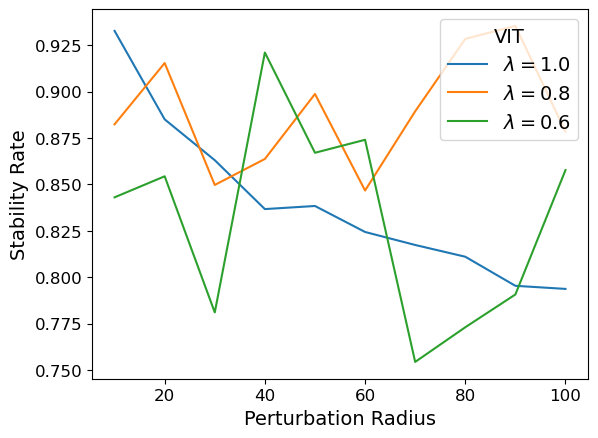

In [7]:
fs = 14
plt.clf()
fig, ax = plt.subplots()

for i, lam in enumerate(lambdas):
    ax.plot(radii, stability_rates[i], label=f"$\lambda = {lam:.1f}$")

ax.set_ylabel("Stability Rate", fontsize=fs)
ax.set_xlabel("Perturbation Radius", fontsize=fs)

# ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.tick_params(axis="x", labelsize=fs-2)
ax.tick_params(axis="y", labelsize=fs-2)

ax.legend(title="VIT", loc="upper right", title_fontsize=fs, fontsize=fs)
plt.savefig("../figures/vit_stability_vs_lambda.png", bbox_inches="tight")